In this notebook, we do visual inspection to create a training set for our CNN shred classifier!

In [9]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from astropy.io import fits
from astropy.table import Table
import numpy as np


Load the dataset!

We create a copy of this dataset with only a few columns to avoid over-writing on the original dataset!

The only columns we need are RA, DEC, TARGETID, SAMPLE, IMAGE_PATH, FILE_PATH and we will add a column for our labelling!

In [ ]:
# shreds_all = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_catalog_v3.fits")
# shreds_all = shreds_all["TARGETID","RA","DEC","FILE_PATH","IMAGE_PATH"]

# ##save this folder and we will be updating for this for visual inspection stuff!
# all_img_paths = []
# for i in range(len(shreds_all)):
#     all_img_paths.append( shreds_all["FILE_PATH"][i] + "/grz_bands_segments.png")

# shreds_all["PNG_PATH"] = all_img_paths

# shreds_all.write("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_VI.fits",overwrite=True)

In [ ]:
# ## read the VI catalog 
# data = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_VI.fits")

# np.random.seed(42)

# #can we scrambe these row
# shuffled_indices = np.random.permutation(len(data))
# data_shuffled = data[shuffled_indices]

# data_shuffled.write("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_VI_labelled.fits",overwrite=True)



In [14]:
data = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_VI_labelled.fits")

#converting the data to pandas df
df = data.to_pandas()

In [15]:
df["IS_SHRED_VI"] == b'nan'

0        False
1        False
2        False
3        False
4        False
         ...  
53372     True
53373     True
53374     True
53375     True
53376     True
Name: IS_SHRED_VI, Length: 53377, dtype: bool

In [7]:
save_path = "/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_VI_labelled.fits"


In [8]:
# # # === Add 'label' column if not present ===
# if "IS_SHRED_VI" not in df.columns:
#     df["IS_SHRED_VI"] = ""

In [9]:

# === Set start index ===
# index = df[df["IS_SHRED_VI"] == ""].index.min()

# if pd.isna(index):
#     index = 0

# Identify rows that are unprocessed: NaN or empty byte string
# unprocessed = df[df["IS_SHRED_VI"].isna() | (df["IS_SHRED_VI"] == b'')]
# # Get the first index of unprocessed row
# index = unprocessed.index.min()

index = df[df["IS_SHRED_VI"] == b'nan'].index.min()

print(index)

# === Display setup ===
image_widget = widgets.Output()
label_widget = widgets.Label()
next_button = widgets.Button(description="Next")
prev_button = widgets.Button(description="Prev")
shred_button = widgets.Button(description="Fragment")
good_button = widgets.Button(description="Good")

# === Save back to FITS ===
def save_fits():
    df_to_save = df.copy()

    # Ensure all object-type columns (usually strings) are cast to fixed-length strings
    for col in df_to_save.select_dtypes(include='object').columns:
        maxlen = df_to_save[col].astype(str).str.len().max()
        df_to_save[col] = df_to_save[col].astype(f'S{maxlen}')

    hdu = fits.BinTableHDU.from_columns(fits.ColDefs(df_to_save.to_records(index=False)))
    hdu.writeto(save_path, overwrite=True)

# === Save label ===
def save_label(label):
    global index
    df.at[index, "IS_SHRED_VI"] = label
    save_fits()

# === Display image ===
def resize_image_maintain_aspect(image, target_size=1024):
    # Get original dimensions
    width, height = image.size
    
    # Calculate the scaling factor to preserve the aspect ratio
    scaling_factor = target_size / max(width, height)
    
    # Compute the new width and height
    new_width = int(width * scaling_factor)
    new_height = int(height * scaling_factor)
    
    # Resize the image (this won't distort it)
    resized_img = image.resize((new_width, new_height))

    return resized_img
    
def show_image():
    image_widget.clear_output(wait=True)
    title = str(df.iloc[index]['PNG_PATH'])
    title = title.replace("/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/","")
    label_widget.value = f"{index + 1}/{len(df)}: {title}"
    with image_widget:
        try:
            img = Image.open(df.iloc[index]["PNG_PATH"])
            # img = img.resize((256, 256))
            plt.figure(figsize = (20,20))
            img = resize_image_maintain_aspect(img)
            plt.imshow(img)
            plt.axis("off")
            plt.show()
        except Exception as e:
            print(f"Could not load image: {e}")

# === Button Callbacks ===
def on_next(b): 
    global index
    if index < len(df) - 1:
        index += 1
        show_image()

def on_prev(b):
    global index
    if index > 0:
        index -= 1
        show_image()

def on_shred(b):
    save_label("fragment")
    on_next(b)

def on_good(b):
    save_label("good")
    on_next(b)

# === Wire Buttons ===
next_button.on_click(on_next)
prev_button.on_click(on_prev)
shred_button.on_click(on_shred)
good_button.on_click(on_good)



1810


In [10]:
# === Layout ===
buttons = widgets.HBox([prev_button, next_button, good_button, shred_button])
display(label_widget, image_widget, buttons)

# === Start ===
show_image()

Label(value='')

Output()

1046/53377: b'south/sweep-110p020-120p025/1164p245/BGS_BRIGHT_tgid_39628361462449758/grz_bands_segments.png'
-> why is the yellow compact source not identified as a star??
1605/53377: b'south/sweep-230p000-240p005/2319p042/BGS_BRIGHT_tgid_39627891255808577/grz_bands_segments.png'
1645/53377: b'south/sweep-050m005-060p000/0567m042/BGS_BRIGHT_tgid_39627683042166732/grz_bands_segments.png'
1715/53377: b'south/sweep-130m010-140m005/1347m077/ELG_tgid_39627600196274367/grz_bands_segments.png'
1897/53377: b'south/sweep-310p005-320p010/3134p057/BGS_BRIGHT_tgid_39627928744495248/grz_bands_segments.png'
Maybe one of the reasons is that it was targeted?

1074/53377: b'south/sweep-210m005-220p000/2168m025/BGS_BRIGHT_tgid_39627727967355167/grz_bands_segments.png'
-> looks like a fragment object and good for apeture, but the source subtraction is too much I think?

1118/53377: south/sweep-120p000-130p005/1280p032/ELG_tgid_39627865389534167/grz_bands_segments.png'
-> example of object where 2 galaxies look very similar color and so aperture photometry fails ... 


1131/53377:south/sweep-180m005-190p000/1818m032/ELG_tgid_39627709264959315/grz_bands_segments.png'
-> example of ELG source on outskirt of very diffuse large galaxy and so aperture mag pipeline fails

In [21]:
data = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_VI_labelled.fits")

##let us get the corresponding meta data for these objects!
data_main = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_catalog_v3.fits")
data_main = data_main["TARGETID","RA","DEC", "MAG_G","MAG_R","MAG_Z","FRACFLUX_G","FRACFLUX_R","FRACFLUX_Z"]

In [27]:
np.min(np.unique(data["TARGETID"]) - np.unique(data_main["TARGETID"]))

0

In [111]:
data_training = data[(data["IS_SHRED_VI"] == "good") | (data["IS_SHRED_VI"] == "fragment")]

In [132]:
# import sys
# import os
# rootdir = '/global/u1/v/virajvm/'
# sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

# from desi_lowz_funcs import match_c_to_catalog

# ##I need to cross-match this to get the files file image data!

# shreds_all = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_catalog_v3.fits")
# temp = shreds_all["TARGETID","RA","DEC","IMAGE_PATH"]

# idx, _, _ = match_c_to_catalog(c_cat=data, catalog_cat=temp, c_ra="RA",c_dec="DEC",catalog_ra="RA",catalog_dec="DEC")

# print(temp[idx]["TARGETID"].data - data["TARGETID"].data)

# data["IMAGE_PATH"] = temp[idx]["IMAGE_PATH"]

# data.write("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_VI_labelled.fits", overwrite=True )

In [10]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
# use a good colormap and don't interpolate the pixels
mpl.rc('image', cmap='viridis', interpolation='none', origin='lower')

In [82]:
frag_comp = np.load("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/shred_classifier_output/fragment_completeness.npy")
good_impure = np.load("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/shred_classifier_output/good_impurity.npy")
thresh_grid = np.linspace(0., 0.999, 40)


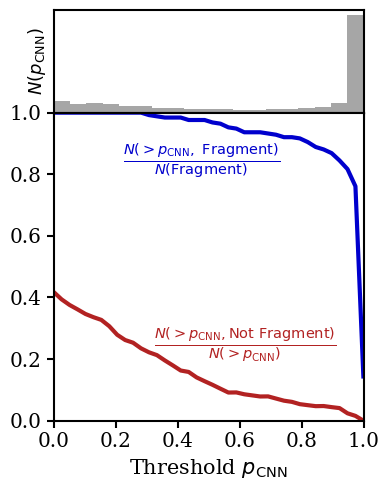

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
x = np.linspace(0, 10, 100)
y = np.sin(x) + 0.1 * np.random.randn(100)


# Create the figure and gridspec
fig = plt.figure(figsize=(4, 4*4/3))
gs = fig.add_gridspec(2, 1, height_ratios=[1, 3], hspace=0.0)

# Top: histogram
ax_hist = fig.add_subplot(gs[0])

# Bottom: line plot
ax_plot = fig.add_subplot(gs[1], sharex=ax_hist)

# Plot histogram
ax_hist.hist(data_main["PCNN_FRAGMENT"], density=True,bins=np.linspace(0,1,20), color='gray', alpha=0.7)
# ax_hist.set_ylabel('')
ax_hist.tick_params(labelbottom=False)  # Hide x labels on hist
ax_hist.set_yticks([])
ax_hist.set_ylabel(r"$N(p_{\rm CNN})$",fontsize = 13)

color_frag = "mediumblue"
color_good = "firebrick"

# Plot line
ax_plot.plot(thresh_grid, frag_comp,lw = 3,color = color_frag)
ax_plot.plot(thresh_grid, good_impure,lw = 3,color = color_good)

# ax_plot.set_xlabel('X')
# ax_plot.set_ylabel('Y')
ax_plot.set_xlim([0,1])
ax_plot.set_ylim([0,1])
ax_plot.set_xlabel(r"Threshold $p_{\rm CNN}$",fontsize = 15)

ax_plot.text(0.325,0.225,r"$\frac{N( > p_{\rm CNN}, \text{Not Fragment}  ) }{N( > p_{\rm CNN}  )}$",fontsize = 15,
             color = color_good)

ax_plot.text(0.225,0.825,r"$\frac{N( > p_{\rm CNN}, \text{ Fragment}  ) }{N( \text{Fragment}  )}$",fontsize = 15,
             color = color_frag)

plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/pcnn_threshold.pdf",dpi = 300,bbox_inches="tight")

plt.show()


In [106]:
data_main = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_catalog_v3.fits")


In [105]:
len(data_main[data_main["PCNN_FRAGMENT"] < 0.3]) / len(data_main)

0.2443309341382246

In [112]:
data_cnn_shred = data_main[data_main["PCNN_FRAGMENT"] >= 0.3]
data_cnn_clean = data_main[data_main["PCNN_FRAGMENT"] < 0.3]


In [123]:
clean_inds = np.random.choice(np.arange(len(data_cnn_clean)), size = 4, replace=False)


In [128]:
## let us load the data for this object!!


In [130]:
temp.shape



(6, 96, 96)

In [144]:
# load the make subplots function!!
import sys
import os

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, sdss_rgb



In [162]:
def get_plotting_inds(main_cat):

    # Get unique samples
    samples = ['BGS_BRIGHT', 'BGS_FAINT', 'ELG'][::-1]
    
    # Dictionary to hold random indices
    random_indices = []
    
    for samp in samples:
        # Find the row indices where sample matches
        mask = main_cat['SAMPLE'] == samp
        matching_indices = np.where(mask)[0]
        # Randomly pick one index
        rand_idx = np.random.choice(matching_indices)
        random_indices.append(rand_idx)
    
    print(random_indices)

    return np.array(random_indices)

In [165]:

clean_inds = get_plotting_inds(data_cnn_clean)



[19400, 12444, 715]
[8199, 6677, 4824]


In [185]:
shred_inds = get_plotting_inds(data_cnn_shred)


[32495, 13180, 1629]


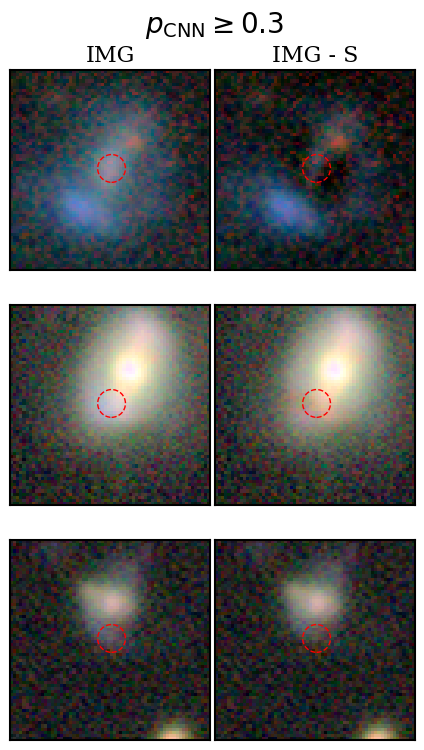

In [229]:
fig, ax = make_subplots(ncol =2, nrow = 3, col_spacing = 0.05, row_spacing = 0.35,plot_size = 2, return_fig=True )


fig.text(0.175, 0.425, r'$p_{\rm CNN} \geq 0.3$', ha='center', va='top', fontsize=20)

# [32495, 13180, 1629]
# [34472, 13451, 1788]

# for i in range(len(ax)):
#     ax[i].set_title(str(i),fontsize = 12)

ax[4].set_title(r"IMG",fontsize = 16)
ax[5].set_title(r"IMG - S",fontsize = 16)


shred_tgids = data_cnn_shred[shred_inds]["TARGETID"].data

##should we make sure one from each?

for j in range(3):
    temp = np.load(f"/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/shred_classifier_output/shred_classifier_input_images/image_{shred_tgids[j]}.npy")

    #we crop to the center 64
    size = 64
    start = (96 - size) // 2
    end = start + size
    temp = temp[:, start:end, start:end]

    #make the rgb image!
    rgb1 = temp[:3]
    #make the sdss rgb image of this!
    rgb1 = sdss_rgb([rgb1[0],rgb1[1],rgb1[2]], ["g","r","z"], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)
 
    rgb2 = temp[3:6]
    rgb2 = sdss_rgb([rgb2[0],rgb2[1],rgb2[2]], ["g","r","z"], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)

    ax[2*j].imshow(rgb1)
    ax[2*j+1].imshow(rgb2)
    ax[2*j].scatter( 32, 32,facecolor="none",edgecolor = "r",lw =1,s=400, ls = "--" )
    ax[2*j+1].scatter( 32, 32,facecolor="none",edgecolor = "r",lw =1,s=400, ls = "--" )
    

    #let us draw a circle at 32 32, 
    

for axi in ax:
    axi.set_yticks([])
    axi.set_xticks([])

plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/shred_egs_pcnn.pdf",dpi=300,bbox_inches="tight")

plt.show()


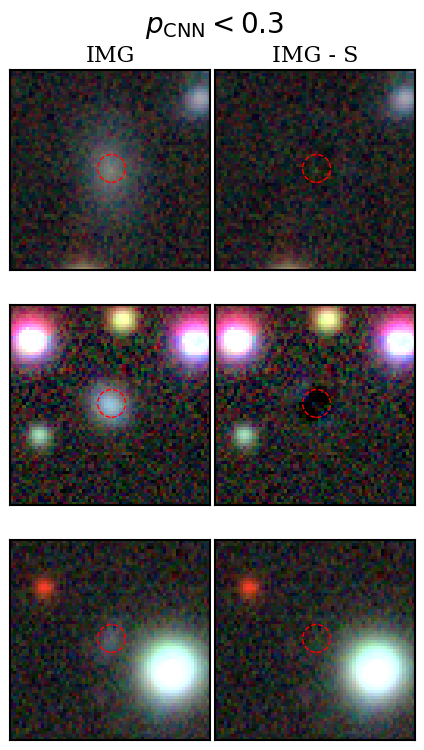

In [230]:
fig, ax = make_subplots(ncol =2, nrow = 3, col_spacing = 0.05, row_spacing = 0.35,plot_size = 2, return_fig=True )


fig.text(0.175, 0.425, r'$p_{\rm CNN} < 0.3$', ha='center', va='top', fontsize=20)

# [32495, 13180, 1629]
# [34472, 13451, 1788]

# for i in range(len(ax)):
#     ax[i].set_title(str(i),fontsize = 12)

ax[4].set_title(r"IMG",fontsize = 16)
ax[5].set_title(r"IMG - S",fontsize = 16)


clean_tgids = data_cnn_clean[clean_inds]["TARGETID"].data

##should we make sure one from each?

for j in range(3):
    temp = np.load(f"/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/shred_classifier_output/shred_classifier_input_images/image_{clean_tgids[j]}.npy")

    #we crop to the center 64
    size = 64
    start = (96 - size) // 2
    end = start + size
    temp = temp[:, start:end, start:end]

    #make the rgb image!
    rgb1 = temp[:3]
    #make the sdss rgb image of this!
    rgb1 = sdss_rgb([rgb1[0],rgb1[1],rgb1[2]], ["g","r","z"], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)
 
    rgb2 = temp[3:6]
    rgb2 = sdss_rgb([rgb2[0],rgb2[1],rgb2[2]], ["g","r","z"], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)

    ax[2*j].imshow(rgb1)
    ax[2*j+1].imshow(rgb2)
    ax[2*j].scatter( 32, 32,facecolor="none",edgecolor = "r",lw =1,s=400, ls = "--" )
    ax[2*j+1].scatter( 32, 32,facecolor="none",edgecolor = "r",lw =1,s=400, ls = "--" )
    

    #let us draw a circle at 32 32, 
    

for axi in ax:
    axi.set_yticks([])
    axi.set_xticks([])

plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/clean_egs_pcnn.pdf",dpi=300,bbox_inches="tight")

plt.show()
